In [1]:
import pandas as pd
import numpy as np
import seaborn
import re
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, 
                             precision_recall_curve, 
                             average_precision_score, 
                             mean_squared_error)

In [2]:
job_posting = pd.read_csv('csv/job_postings_training_set.csv')
job_posting.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

## 將特徵區分為下述幾種類型
* 數值型 (numerical)
* 文本型 (textual)
* 類別型 (categorical)

In [100]:
Y = job_posting['fraudulent']
numerical = job_posting.select_dtypes(include=['number'])
textual = job_posting[['title', 'company_profile', 'description', 'requirements', 'benefits']]
categorical = job_posting.select_dtypes(include=['object']).drop(textual, axis=1)

In [101]:
print(f'fraudulent distribution: {Y.nunique()}\n')
print(f'categorical value distribution:\n\n {categorical.nunique()}\n')
print(f'numerical value distribution:\n\n {numerical.nunique()}\n')
print(f'textual value distribution:\n\n {textual.nunique()}\n')

fraudulent distribution: 2

categorical value distribution:

 location               3097
department             1337
salary_range            874
employment_type           5
required_experience       7
required_education       13
industry                131
function                 37
dtype: int64

numerical value distribution:

 job_id              17828
telecommuting           2
has_company_logo        2
has_questions           2
fraudulent              2
dtype: int64

textual value distribution:

 title              11188
company_profile     1707
description        14677
requirements       11881
benefits            6131
dtype: int64



### 將 value difference 數量少於 100 的做單因子 & 關聯性觀察

In [102]:
def feat_exploration(df, topN=5):
    for feat in df:
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # 單因子觀察
        ax1 = seaborn.countplot(x=feat, data=job_posting, ax=ax1, order=job_posting[feat].value_counts().iloc[:topN].index)
        ax1.tick_params(axis='x', labelrotation=90)

        # 關聯性觀察
        if feat == 'fraudulent':
            continue
        count_groupby_Y = (job_posting.groupby([feat])['fraudulent']
                           .value_counts()
                           .rename('count')
                           .reset_index()
                           .sort_values('fraudulent'))
        total_count = job_posting['fraudulent'].value_counts().rename('total')
        counts_ratio = pd.merge(count_groupby_Y, total_count, how='left', left_on='fraudulent', right_index=True)
        counts_ratio['ratio'] = counts_ratio['count'] / counts_ratio['total'] * 100  
        ax2 = seaborn.barplot(x=feat, y="ratio", hue="fraudulent", data=counts_ratio, ax=ax2, order=job_posting[feat].value_counts().iloc[:topN].index)
        ax2.tick_params(axis='x', labelrotation=90)
                

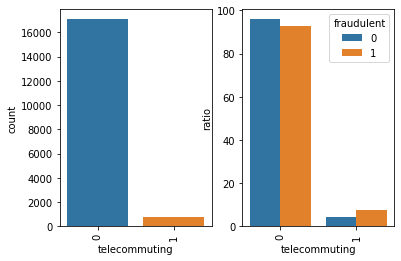

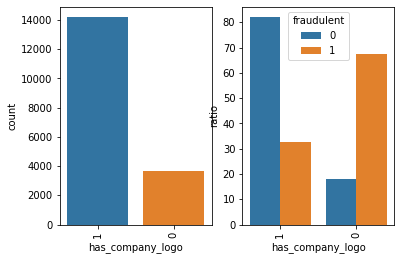

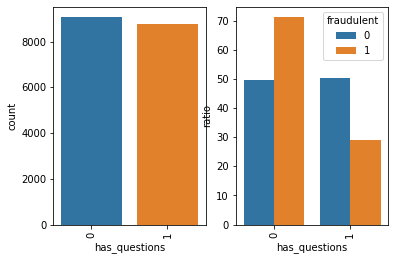

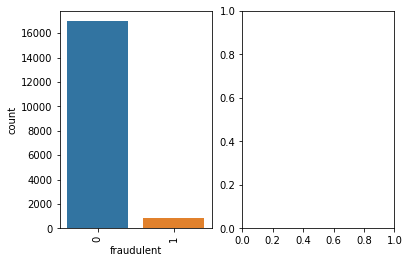

In [103]:
# Numerical features
critical = numerical.nunique() < 100
num_less100 = critical.index[critical]
feat_exploration(num_less100)

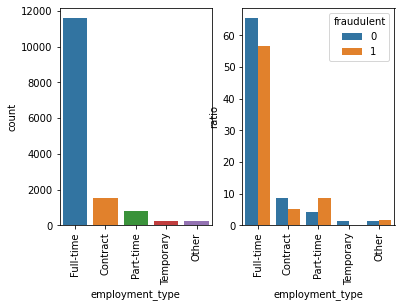

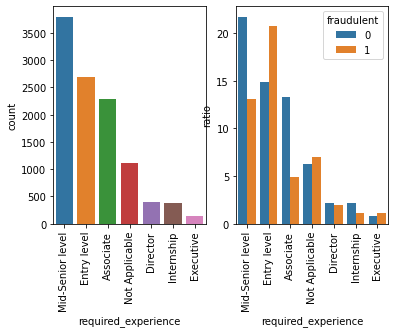

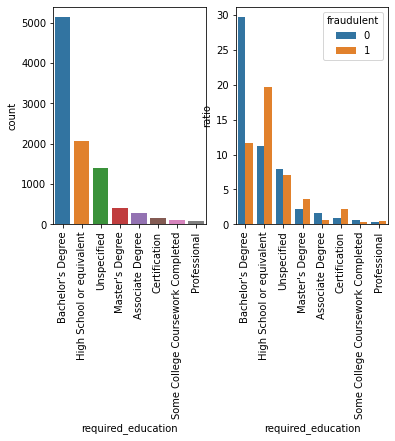

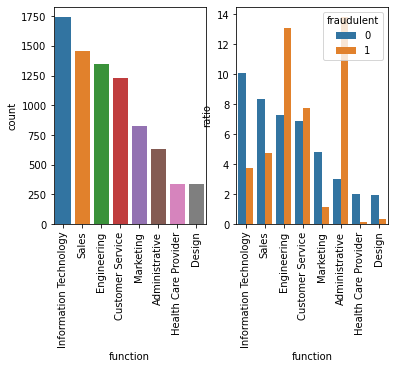

In [98]:
# Categorical features
critical = categorical.nunique() < 100
cate_less100 = critical.index[critical]
feat_exploration(cate_less100, topN=8)

# TODO exploration
1. 將 value difference 大於 100 的 features 做各別前處理
2. 將上述前處理過的可用 features 做單因子 & 關聯性觀察

# TODO preprocess
1. Remove stop_word
2. Stemming